# Generative Adversarial Network Tutorial 00

In particle physics, Generative Adversarial Networks hold a lot of promise for studying data/MC differences.  In principle, the physics tools used for simulation of particle interaction data are quite good, but they are never perfect.  Additionally, they are always imperfect in difficult to model ways.  Many experiments spend a lot of time studying the differences between the output of their simulation and their real detector data, and a deep network that can learn these differences is really useful for making progress.

In this tutorial, I'll cover some basics of generative adversarial networks with very simple feed-forward neural networks (not even convolutional) as a demonstration of the basic techniques of GANs.  You can read the original paper on GANs here: https://arxiv.org/abs/1406.2661.  The basic idea is you train two networks to compete with each other.  The first (called the discriminator) makes a decision on whether or not the images it's looking at are real or fake.  The second (called the generator) tries to generate fake images from random noise to fool the discriminator.

In the years since the original paper came out, GANs have grown increasinly more sophisticated and impressive, especially with the advent of the Deep Convolutional Generative Adversarial Network (DCGAN, original paper: https://arxiv.org/abs/1511.06434).  For this tutorial, we're going to eschew all of the recent advances to make a GAN that can generate artificial digits based on the mnist data set.  By stripping the networks down to their basics, it's easier to focus on the core aspects of the loss function and outputs, and to avoid the complications of training on GPUs, etc.

## MNIST data set

The mnist data set is one of the most famous collections of labeled images that exists.  You can read all about it at the original website (http://yann.lecun.com/exdb/mnist/), but it has a few nice advantages that make it ideal for learning:
 * It's open, and has convient wrappers in many languages (we'll use tensorflows soon)
 * It's a large data set (60k training images) but each image is small (28x28)
 * The data has been preprocessed to center images of digits and make them easier to use
 
Basically, you can focus on the fundamentals with this data set, which is why we'll use it here.  Some examples of loading it with tensorflow (more here: https://www.tensorflow.org/get_started/mnist/beginners)

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
import tensorflow as tf
import numpy
from tensorflow.examples.tutorials.mnist import input_data

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


With tensorflow, you can specify which device to use.  The next cell will tell you what's available, and you can select from there.  By default, I select "/gpu:0" but you can change this below

In [2]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/gpu:0"

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10429023499755835644
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11946606592
locality {
  bus_id: 1
}
incarnation: 15153145144965522907
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:01:00.0"
]


In [3]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_images, mnist_labels = mnist.train.next_batch(batch_size=5)

Here, we've loaded the mnist data from the tensorflow helper class, and asked for the next batch of images and labels.  Let's view those to see what the data looks like before delving into the network:

In [5]:
print "mnist_images.shape: {}".format(mnist_images.shape)
print "mnist_labels.shape: {}".format(mnist_labels.shape)

mnist_images.shape: (5, 784)
mnist_labels.shape: (5,)


As expected, variables are arrays with the outermost dimension equal to 5.  The images, though, comes unpacked as a 1D array per image instead of a 2D array.  We can reshape this to what we're more familar with, since we know mnist images are 28x28:

In [6]:
mnist_images = numpy.reshape(mnist_images, (-1, 28, 28)) # -1 can be used as a placeholder for batch size here

In [7]:
print "mnist_images.shape: {}".format(mnist_images.shape)


mnist_images.shape: (5, 28, 28)


Matplotlib gives a good interface for viewing these images in a notebook (or even in general, in python):

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

This image is labeled as 6


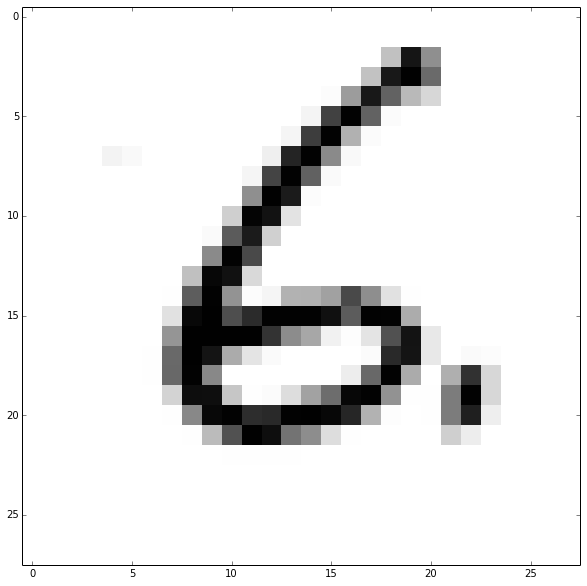

In [9]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(mnist_images[index], cmap="Greys", interpolation="none")
print "This image is labeled as {}".format(mnist_labels[index])
plt.show()

Drawn like this, you can see each individual pixel clearly.  It's not a high resolution image, but you can clearly tell what the digit is!

## Building a model for a GAN

We'll start to put together a network for the GAN, first by defining some useful constants that we'll need to call on multiple times:

In [10]:
BASE_LEARNING_RATE = 0.000001
BATCH_SIZE=64 # Keep this even
LOGDIR="./mnist_gan_logs/"

Additionally, let's make sure we have the same graph by defining it:

In [11]:
tf.reset_default_graph()
g = tf.Graph()

Set up the placeholders for the input variables.  We'll need to input both real images and random noise, so make a placeholder for both.  Additionally, based on this blog post (http://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/) I add random gaussian noise to the real and fake images as they are fed to the discriminator to help stabalize training.

In [12]:
with tf.device(default_device):
    with g.as_default():
        # Input noise to the generator:
        noise_tensor = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 10*10], name="noise")
        fake_input   = tf.reshape(noise_tensor, (tf.shape(noise_tensor)[0], 10,10, 1))

        # Placeholder for the discriminator input:
        real_flat  = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 784], name='x')
        # label_tensor = tf.placeholder(tf.float32, [BATCH_SIZE, 1], name='labels')
        real_images  = tf.reshape(real_flat, (tf.shape(real_flat)[0], 28, 28, 1))

        # We augment the input to the discriminator with gaussian noise
        # This makes it harder for the discriminator to do it's job, preventing
        # it from always "winning" the GAN min/max contest
        real_noise = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 28, 28, 1], name="real_noise")
        fake_noise = tf.placeholder(tf.float32, [int(BATCH_SIZE*0.5), 28, 28, 1], name="fake_noise")

        real_images = real_noise + real_images


Notice how the input tensors (noise_tensor, real_images) are shaped in the 'flattened' way: (N/2, 100) for noise, (N/2, 784) for real images.  This lets me input the mnist images directly to tensorflow, as well as the noise.  They are then reshaped to be like tensorflow images (Batch, H, W, Filters).

### Image Discriminator:

Make a function to build the discriminator, using fully connected networks.  Note that a convolutional layer with the stride equal to the image size *is* a fully connected layer.

In [13]:
def build_discriminator(input_tensor, reuse,reg=0.1):
    # Use scoping to keep the variables nicely organized in the graph.
    # Scoping is good practice always, but it's *essential* here as we'll see later on
    with tf.variable_scope("mnist_discriminator", reuse=reuse):
        x = tf.layers.conv2d(input_tensor,
                             filters=128, #Connecting to 128 output neurons, each it's own filter
                             kernel_size=[28,28], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_1")
        # Apply a non linearity:
        x = tf.nn.relu(x)
        # That maps to a hidden layer, shape is (B, 1, 1, 128), let's now map to a single output
        x = tf.layers.conv2d(x,
                             filters=1,         #Connecting to 1 output neuron
                             kernel_size=[1,1], 
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_2")
        
        # Since we want to predict "real" or "fake", an output of 0 or 1 is desired.  sigmoid is perfect for this:
        x = tf.nn.sigmoid(x, name="discriminator_sigmoid")
        #Reshape this to bring it down to just one output per image:
        x = tf.reshape(x, (x.get_shape().as_list()[0],))
        return x

In [14]:
with tf.device(default_device):
    with g.as_default():
        real_image_logits = build_discriminator(real_images, reuse=False,reg=0.2)

Now we can define a function to generate random images from noise:

In [15]:
def build_generator(input_tensor, reg=0.2):
    # Again, scoping is essential here:
    with tf.variable_scope("mnist_generator"):
        # Input is Bx10x10x1, let's use two hidden layers this time to upsample to 28x28:
        x = tf.layers.conv2d(input_tensor,
                             filters=1028,
                             kernel_size=[10,10], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_1")
        
        # Apply nonlinearity, this time using a 'leaky relu':
        x = tf.maximum(x, 0.1*x)
        
        
        # Another fully connected layer, no change to resolution yet:
        x = tf.layers.conv2d(x,
                             filters=1028,
                             kernel_size=[1,1], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_2")
        
        # Apply nonlinearity, this time using a 'leaky relu':
        x = tf.maximum(x, 0.1*x)
        
        
        
        # Final layer, step up to "full" resolution and then reshape the tensor:
        x = tf.layers.conv2d(x,
                             filters=784, #784 is a 28x28 image
                             kernel_size=[1,1], # Use the size of the mnist images to make this FC
                             strides=(1, 1),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=reg),
                             name="fully_connected_3")
        
        # Reshape to match mnist images:
        x = tf.reshape(x, (-1, 28, 28, 1))
        
        # The final non linearity applied here is to map the images onto the [-1,1] range.
        x = tf.nn.tanh(x, name="generator_tanh")
        return x

In [16]:
with tf.device(default_device):
    with g.as_default():
        fake_images = build_generator(fake_input) 

We also need to be able to run the discriminator on the fake images, so set that up too.  Since it trains on both real and fake images, set reuse=True here:

In [17]:
with tf.device(default_device):
    with g.as_default():
        fake_image_logits = build_discriminator(fake_images, reuse=True, reg=0.2)

### Loss functions

We can now define our loss functions.  Note that we have to define the loss function for the generator and discriminator seperately:

In [18]:
with tf.device(default_device):
    # Build the loss functions:
    with g.as_default():
        with tf.name_scope("cross_entropy") as scope:

            #Discriminator loss on real images (classify as 1):
            d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_image_logits,
                labels = tf.ones_like(real_image_logits)))
            #Discriminator loss on fake images (classify as 0):
            d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_logits,
                labels = tf.zeros_like(fake_image_logits)))

            # Total discriminator loss is the sum:
            d_loss_total = d_loss_real + d_loss_fake

            # This is the adverserial step: g_loss tries to optimize fake_logits to one,
            # While d_loss_fake tries to optimize fake_logits to zero.
            g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_image_logits,
                labels = tf.ones_like(fake_image_logits)))

            # This code is useful if you'll use tensorboard to monitor training:
            d_loss_summary = tf.summary.scalar("Discriminator_Real_Loss", d_loss_real)
            d_loss_summary = tf.summary.scalar("Discriminator_Fake_Loss", d_loss_fake)
            d_loss_summary = tf.summary.scalar("Discriminator_Total_Loss", d_loss_total)
            d_loss_summary = tf.summary.scalar("Generator_Loss", g_loss)


It's also useful to compute accuracy, just to see how the training is going:

In [19]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("accuracy") as scope:
            # Compute the discriminator accuracy on real data, fake data, and total:
            accuracy_real  = tf.reduce_mean(tf.cast(tf.equal(tf.round(real_image_logits), 
                                                             tf.ones_like(real_image_logits)), 
                                                    tf.float32))
            accuracy_fake  = tf.reduce_mean(tf.cast(tf.equal(tf.round(fake_image_logits), 
                                                             tf.zeros_like(fake_image_logits)), 
                                                    tf.float32))

            total_accuracy = 0.5*(accuracy_fake +  accuracy_real)

            # Again, useful for tensorboard:
            acc_real_summary = tf.summary.scalar("Real_Accuracy", accuracy_real)
            acc_real_summary = tf.summary.scalar("Fake_Accuracy", accuracy_fake)
            acc_real_summary = tf.summary.scalar("Total_Accuracy", total_accuracy)

### Independant Optimizers

To allow the generator and discriminator to compete and update seperately, we use two distinct optimizers.  This step is why it was essential earlier to have the scopes different for the generator and optimizer: we can select all variables in each scope to go to their own optimizer.  So, even though the generator loss calculation runs the discriminator, the update step for the generator **only** affects the variables inside the generator

In [20]:
with tf.device(default_device):
    with g.as_default():
        with tf.name_scope("training") as scope:
            # Global steps are useful for restoring training:
            global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

            # Make sure the optimizers are only operating on their own variables:

            all_variables      = tf.trainable_variables()
            discriminator_vars = [v for v in all_variables if v.name.startswith('mnist_discriminator/')]
            generator_vars     = [v for v in all_variables if v.name.startswith('mnist_generator/')]


            discriminator_optimizer = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                d_loss_total, global_step=global_step, var_list=discriminator_vars)
            generator_optimizer     = tf.train.AdamOptimizer(BASE_LEARNING_RATE, 0.5).minimize(
                g_loss, global_step=global_step, var_list=generator_vars)


### Image snapshots

It's useful to snapshot images into tensorboard to see how things are going, as well:

In [21]:
with tf.device(default_device):
    with g.as_default():
        tf.summary.image('fake_images', fake_images, max_outputs=4)
        tf.summary.image('real_images', real_images, max_outputs=4)


## Training the networks

There are lots of philosophys on training GANs.  Here, we'll do something simple and just alternate updates. To save the network and keep track of training variables, set up a summary writer:

In [22]:
with tf.device(default_device):
    with g.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)

Set up a session for training using an interactive session:

In [23]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        RESTORE=False
        if not RESTORE:
            sess.run(tf.global_variables_initializer())
            train_writer.add_graph(sess.graph)
            saver = tf.train.Saver()
        else: 
            latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
            print "Restoring model from {}".format(latest_checkpoint)
            saver = tf.train.Saver()
            saver.restore(sess, latest_checkpoint)



        print "Begin training ..."
        # Run training loop
        for i in xrange(50000):
            step = sess.run(global_step)

            # Receive data (this will hang if IO thread is still running = this
            # will wait for thread to finish & receive data)

            sigma = max(1.0*(40000. - step) / (40000), 0.01)

            # Update the generator:
            # Prepare the input to the networks:
            fake_input = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))
            real_data, label = mnist.train.next_batch(int(BATCH_SIZE*0.5))
            real_data = 2*(real_data - 0.5)

            real_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),28,28,1))
            fake_noise_addition = numpy.random.normal(scale=sigma,size=(int(BATCH_SIZE*0.5),28,28,1))


            [  acc_fake, _ ] = sess.run(
                [accuracy_fake, 
                 generator_optimizer], 
                feed_dict = {noise_tensor: fake_input,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})

            # Update the discriminator:
            # Prepare the input to the networks:
            fake = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))
            real_data, label = mnist.train.next_batch(int(BATCH_SIZE*0.5))
            real_data = 2*(real_data - 0.5)
            [generated_mnist, _] = sess.run([fake_images, 
                                            discriminator_optimizer], 
                                            feed_dict = {noise_tensor : fake_input,
                                                         real_flat : real_data,
                                                         real_noise: real_noise_addition,
                                                         fake_noise: fake_noise_addition})




            [summary, g_l, acc_fake, d_l_r, acc] = sess.run(
                [merged_summary, g_loss, accuracy_fake,
                 d_loss_real, total_accuracy],
                feed_dict = {noise_tensor : fake,
                             real_flat : real_data,
                             real_noise: real_noise_addition,
                             fake_noise: fake_noise_addition})


            train_writer.add_summary(summary, step)


            if step != 0 and step % 500 == 0:
                saver.save(
                    sess,
                    LOGDIR+"/checkpoints/save",
                    global_step=step)


            # train_writer.add_summary(summary, i)
            # sys.stdout.write('Training in progress @ step %d\n' % (step))
            if step % 50 == 0:
                print 'Training in progress @ global_step %d, g_loss %g, d_loss %g accuracy %g' % (step, g_l, d_l_r, acc)


Begin training ...
Training in progress @ global_step 0, g_loss 0.474298, d_loss 0.488224 accuracy 0.546875
Training in progress @ global_step 50, g_loss 0.47426, d_loss 0.476399 accuracy 0.671875
Training in progress @ global_step 100, g_loss 0.474177, d_loss 0.466159 accuracy 0.78125
Training in progress @ global_step 150, g_loss 0.474094, d_loss 0.456197 accuracy 0.703125
Training in progress @ global_step 200, g_loss 0.47405, d_loss 0.452239 accuracy 0.71875
Training in progress @ global_step 250, g_loss 0.473955, d_loss 0.444132 accuracy 0.5625
Training in progress @ global_step 300, g_loss 0.473882, d_loss 0.434409 accuracy 0.53125
Training in progress @ global_step 350, g_loss 0.473785, d_loss 0.427326 accuracy 0.515625
Training in progress @ global_step 400, g_loss 0.473747, d_loss 0.420297 accuracy 0.515625
Training in progress @ global_step 450, g_loss 0.473643, d_loss 0.416134 accuracy 0.5
Training in progress @ global_step 500, g_loss 0.473587, d_loss 0.4077 accuracy 0.5
Tr

Training in progress @ global_step 4750, g_loss 0.44737, d_loss 0.329173 accuracy 0.5
Training in progress @ global_step 4800, g_loss 0.447346, d_loss 0.328091 accuracy 0.5
Training in progress @ global_step 4850, g_loss 0.447032, d_loss 0.328989 accuracy 0.5
Training in progress @ global_step 4900, g_loss 0.446346, d_loss 0.328675 accuracy 0.5
Training in progress @ global_step 4950, g_loss 0.447159, d_loss 0.329456 accuracy 0.5
Training in progress @ global_step 5000, g_loss 0.447148, d_loss 0.3299 accuracy 0.5
Training in progress @ global_step 5050, g_loss 0.446806, d_loss 0.330066 accuracy 0.5
Training in progress @ global_step 5100, g_loss 0.44622, d_loss 0.330048 accuracy 0.5
Training in progress @ global_step 5150, g_loss 0.446756, d_loss 0.330171 accuracy 0.5
Training in progress @ global_step 5200, g_loss 0.446526, d_loss 0.331282 accuracy 0.5
Training in progress @ global_step 5250, g_loss 0.446657, d_loss 0.332836 accuracy 0.5
Training in progress @ global_step 5300, g_loss

Training in progress @ global_step 9500, g_loss 0.437231, d_loss 0.374288 accuracy 0.5
Training in progress @ global_step 9550, g_loss 0.437729, d_loss 0.372731 accuracy 0.5
Training in progress @ global_step 9600, g_loss 0.438187, d_loss 0.373945 accuracy 0.5
Training in progress @ global_step 9650, g_loss 0.437455, d_loss 0.376205 accuracy 0.5
Training in progress @ global_step 9700, g_loss 0.437903, d_loss 0.374761 accuracy 0.5
Training in progress @ global_step 9750, g_loss 0.437591, d_loss 0.374469 accuracy 0.5
Training in progress @ global_step 9800, g_loss 0.437648, d_loss 0.375422 accuracy 0.5
Training in progress @ global_step 9850, g_loss 0.437401, d_loss 0.376595 accuracy 0.5
Training in progress @ global_step 9900, g_loss 0.437417, d_loss 0.378406 accuracy 0.5
Training in progress @ global_step 9950, g_loss 0.437133, d_loss 0.378212 accuracy 0.5
Training in progress @ global_step 10000, g_loss 0.437205, d_loss 0.378601 accuracy 0.5
Training in progress @ global_step 10050, 

Training in progress @ global_step 14200, g_loss 0.454661, d_loss 0.424019 accuracy 0.5
Training in progress @ global_step 14250, g_loss 0.455096, d_loss 0.423088 accuracy 0.5
Training in progress @ global_step 14300, g_loss 0.455858, d_loss 0.426434 accuracy 0.5
Training in progress @ global_step 14350, g_loss 0.456182, d_loss 0.42668 accuracy 0.5
Training in progress @ global_step 14400, g_loss 0.456312, d_loss 0.42725 accuracy 0.5
Training in progress @ global_step 14450, g_loss 0.456804, d_loss 0.426644 accuracy 0.5
Training in progress @ global_step 14500, g_loss 0.456993, d_loss 0.426888 accuracy 0.5
Training in progress @ global_step 14550, g_loss 0.457344, d_loss 0.426909 accuracy 0.5
Training in progress @ global_step 14600, g_loss 0.45756, d_loss 0.427904 accuracy 0.5
Training in progress @ global_step 14650, g_loss 0.457923, d_loss 0.429113 accuracy 0.5
Training in progress @ global_step 14700, g_loss 0.458293, d_loss 0.429068 accuracy 0.5
Training in progress @ global_step 

Training in progress @ global_step 18900, g_loss 0.476568, d_loss 0.453356 accuracy 1
Training in progress @ global_step 18950, g_loss 0.476883, d_loss 0.452631 accuracy 1
Training in progress @ global_step 19000, g_loss 0.47679, d_loss 0.453056 accuracy 1
Training in progress @ global_step 19050, g_loss 0.476828, d_loss 0.451795 accuracy 1
Training in progress @ global_step 19100, g_loss 0.476805, d_loss 0.454191 accuracy 1
Training in progress @ global_step 19150, g_loss 0.476916, d_loss 0.453349 accuracy 1
Training in progress @ global_step 19200, g_loss 0.476981, d_loss 0.453843 accuracy 1
Training in progress @ global_step 19250, g_loss 0.477032, d_loss 0.455076 accuracy 1
Training in progress @ global_step 19300, g_loss 0.477079, d_loss 0.453483 accuracy 1
Training in progress @ global_step 19350, g_loss 0.477147, d_loss 0.453033 accuracy 1
Training in progress @ global_step 19400, g_loss 0.477309, d_loss 0.454762 accuracy 1
Training in progress @ global_step 19450, g_loss 0.4774

Training in progress @ global_step 23700, g_loss 0.479168, d_loss 0.446026 accuracy 1
Training in progress @ global_step 23750, g_loss 0.4792, d_loss 0.44289 accuracy 1
Training in progress @ global_step 23800, g_loss 0.479203, d_loss 0.443565 accuracy 1
Training in progress @ global_step 23850, g_loss 0.479179, d_loss 0.438818 accuracy 1
Training in progress @ global_step 23900, g_loss 0.479358, d_loss 0.441956 accuracy 1
Training in progress @ global_step 23950, g_loss 0.479347, d_loss 0.443668 accuracy 1
Training in progress @ global_step 24000, g_loss 0.47936, d_loss 0.443562 accuracy 1
Training in progress @ global_step 24050, g_loss 0.479445, d_loss 0.444432 accuracy 1
Training in progress @ global_step 24100, g_loss 0.479409, d_loss 0.443124 accuracy 1
Training in progress @ global_step 24150, g_loss 0.479528, d_loss 0.441759 accuracy 1
Training in progress @ global_step 24200, g_loss 0.479661, d_loss 0.442624 accuracy 1
Training in progress @ global_step 24250, g_loss 0.479632,

Training in progress @ global_step 28500, g_loss 0.480871, d_loss 0.432128 accuracy 1
Training in progress @ global_step 28550, g_loss 0.48102, d_loss 0.436996 accuracy 1
Training in progress @ global_step 28600, g_loss 0.480702, d_loss 0.435603 accuracy 1
Training in progress @ global_step 28650, g_loss 0.48103, d_loss 0.435422 accuracy 1
Training in progress @ global_step 28700, g_loss 0.480687, d_loss 0.430749 accuracy 1
Training in progress @ global_step 28750, g_loss 0.48051, d_loss 0.436151 accuracy 1
Training in progress @ global_step 28800, g_loss 0.480668, d_loss 0.435164 accuracy 1
Training in progress @ global_step 28850, g_loss 0.480811, d_loss 0.43372 accuracy 1
Training in progress @ global_step 28900, g_loss 0.480597, d_loss 0.435963 accuracy 1
Training in progress @ global_step 28950, g_loss 0.481129, d_loss 0.431839 accuracy 1
Training in progress @ global_step 29000, g_loss 0.481143, d_loss 0.435139 accuracy 1
Training in progress @ global_step 29050, g_loss 0.480874,

Training in progress @ global_step 33150, g_loss 0.476366, d_loss 0.424585 accuracy 0.875
Training in progress @ global_step 33200, g_loss 0.477818, d_loss 0.424003 accuracy 0.890625
Training in progress @ global_step 33250, g_loss 0.476738, d_loss 0.426022 accuracy 0.875
Training in progress @ global_step 33300, g_loss 0.477048, d_loss 0.421184 accuracy 0.890625
Training in progress @ global_step 33350, g_loss 0.476647, d_loss 0.425456 accuracy 0.84375
Training in progress @ global_step 33400, g_loss 0.476277, d_loss 0.417226 accuracy 0.875
Training in progress @ global_step 33450, g_loss 0.476356, d_loss 0.424794 accuracy 0.875
Training in progress @ global_step 33500, g_loss 0.478024, d_loss 0.426097 accuracy 0.9375
Training in progress @ global_step 33550, g_loss 0.474159, d_loss 0.419482 accuracy 0.765625
Training in progress @ global_step 33600, g_loss 0.474874, d_loss 0.426869 accuracy 0.8125
Training in progress @ global_step 33650, g_loss 0.474768, d_loss 0.423448 accuracy 0.8

Training in progress @ global_step 37650, g_loss 0.468, d_loss 0.417179 accuracy 0.671875
Training in progress @ global_step 37700, g_loss 0.469376, d_loss 0.417281 accuracy 0.71875
Training in progress @ global_step 37750, g_loss 0.463332, d_loss 0.413636 accuracy 0.59375
Training in progress @ global_step 37800, g_loss 0.467657, d_loss 0.417635 accuracy 0.703125
Training in progress @ global_step 37850, g_loss 0.466386, d_loss 0.415847 accuracy 0.671875
Training in progress @ global_step 37900, g_loss 0.467459, d_loss 0.412988 accuracy 0.640625
Training in progress @ global_step 37950, g_loss 0.461311, d_loss 0.4157 accuracy 0.5625
Training in progress @ global_step 38000, g_loss 0.463819, d_loss 0.413943 accuracy 0.5625
Training in progress @ global_step 38050, g_loss 0.465853, d_loss 0.417841 accuracy 0.640625
Training in progress @ global_step 38100, g_loss 0.466485, d_loss 0.41604 accuracy 0.625
Training in progress @ global_step 38150, g_loss 0.467465, d_loss 0.417025 accuracy 0

Training in progress @ global_step 42150, g_loss 0.469637, d_loss 0.416419 accuracy 0.6875
Training in progress @ global_step 42200, g_loss 0.468208, d_loss 0.412382 accuracy 0.625
Training in progress @ global_step 42250, g_loss 0.468283, d_loss 0.412915 accuracy 0.578125
Training in progress @ global_step 42300, g_loss 0.468972, d_loss 0.413718 accuracy 0.59375
Training in progress @ global_step 42350, g_loss 0.469406, d_loss 0.410397 accuracy 0.609375
Training in progress @ global_step 42400, g_loss 0.467189, d_loss 0.413406 accuracy 0.609375
Training in progress @ global_step 42450, g_loss 0.46775, d_loss 0.411295 accuracy 0.59375
Training in progress @ global_step 42500, g_loss 0.46996, d_loss 0.405822 accuracy 0.640625
Training in progress @ global_step 42550, g_loss 0.468393, d_loss 0.41405 accuracy 0.625
Training in progress @ global_step 42600, g_loss 0.46831, d_loss 0.414771 accuracy 0.609375
Training in progress @ global_step 42650, g_loss 0.470622, d_loss 0.419561 accuracy 

Training in progress @ global_step 46650, g_loss 0.466128, d_loss 0.408987 accuracy 0.703125
Training in progress @ global_step 46700, g_loss 0.462884, d_loss 0.411634 accuracy 0.640625
Training in progress @ global_step 46750, g_loss 0.469025, d_loss 0.409515 accuracy 0.703125
Training in progress @ global_step 46800, g_loss 0.46875, d_loss 0.409715 accuracy 0.65625
Training in progress @ global_step 46850, g_loss 0.467719, d_loss 0.41166 accuracy 0.625
Training in progress @ global_step 46900, g_loss 0.466013, d_loss 0.407436 accuracy 0.671875
Training in progress @ global_step 46950, g_loss 0.465911, d_loss 0.412051 accuracy 0.6875
Training in progress @ global_step 47000, g_loss 0.468367, d_loss 0.409456 accuracy 0.6875
Training in progress @ global_step 47050, g_loss 0.467346, d_loss 0.418328 accuracy 0.71875
Training in progress @ global_step 47100, g_loss 0.467367, d_loss 0.417791 accuracy 0.734375
Training in progress @ global_step 47150, g_loss 0.467799, d_loss 0.403907 accura

Training in progress @ global_step 51150, g_loss 0.456556, d_loss 0.412377 accuracy 0.515625
Training in progress @ global_step 51200, g_loss 0.45933, d_loss 0.414807 accuracy 0.5625
Training in progress @ global_step 51250, g_loss 0.463512, d_loss 0.410592 accuracy 0.546875
Training in progress @ global_step 51300, g_loss 0.454988, d_loss 0.404775 accuracy 0.53125
Training in progress @ global_step 51350, g_loss 0.456967, d_loss 0.411651 accuracy 0.515625
Training in progress @ global_step 51400, g_loss 0.455697, d_loss 0.414588 accuracy 0.515625
Training in progress @ global_step 51450, g_loss 0.461221, d_loss 0.41 accuracy 0.515625
Training in progress @ global_step 51500, g_loss 0.454829, d_loss 0.412263 accuracy 0.515625
Training in progress @ global_step 51550, g_loss 0.458796, d_loss 0.414457 accuracy 0.53125
Training in progress @ global_step 51600, g_loss 0.454596, d_loss 0.407375 accuracy 0.5
Training in progress @ global_step 51650, g_loss 0.457755, d_loss 0.411353 accuracy 

Training in progress @ global_step 55650, g_loss 0.469593, d_loss 0.419283 accuracy 0.703125
Training in progress @ global_step 55700, g_loss 0.466578, d_loss 0.411963 accuracy 0.59375
Training in progress @ global_step 55750, g_loss 0.466524, d_loss 0.412376 accuracy 0.5625
Training in progress @ global_step 55800, g_loss 0.469171, d_loss 0.419139 accuracy 0.703125
Training in progress @ global_step 55850, g_loss 0.471476, d_loss 0.416193 accuracy 0.71875
Training in progress @ global_step 55900, g_loss 0.466365, d_loss 0.418682 accuracy 0.609375
Training in progress @ global_step 55950, g_loss 0.467094, d_loss 0.420674 accuracy 0.578125
Training in progress @ global_step 56000, g_loss 0.46472, d_loss 0.420563 accuracy 0.640625
Training in progress @ global_step 56050, g_loss 0.470816, d_loss 0.414267 accuracy 0.703125
Training in progress @ global_step 56100, g_loss 0.469424, d_loss 0.414695 accuracy 0.671875
Training in progress @ global_step 56150, g_loss 0.4649, d_loss 0.415547 ac

Training in progress @ global_step 60150, g_loss 0.47144, d_loss 0.430205 accuracy 0.703125
Training in progress @ global_step 60200, g_loss 0.472878, d_loss 0.438228 accuracy 0.75
Training in progress @ global_step 60250, g_loss 0.471575, d_loss 0.425794 accuracy 0.734375
Training in progress @ global_step 60300, g_loss 0.470522, d_loss 0.42881 accuracy 0.6875
Training in progress @ global_step 60350, g_loss 0.47241, d_loss 0.429103 accuracy 0.78125
Training in progress @ global_step 60400, g_loss 0.472612, d_loss 0.432498 accuracy 0.796875
Training in progress @ global_step 60450, g_loss 0.469964, d_loss 0.427884 accuracy 0.703125
Training in progress @ global_step 60500, g_loss 0.472064, d_loss 0.423565 accuracy 0.734375
Training in progress @ global_step 60550, g_loss 0.470438, d_loss 0.423302 accuracy 0.671875
Training in progress @ global_step 60600, g_loss 0.474149, d_loss 0.430026 accuracy 0.796875
Training in progress @ global_step 60650, g_loss 0.471755, d_loss 0.42778 accura

Training in progress @ global_step 64650, g_loss 0.467655, d_loss 0.436708 accuracy 0.734375
Training in progress @ global_step 64700, g_loss 0.46882, d_loss 0.432733 accuracy 0.75
Training in progress @ global_step 64750, g_loss 0.46209, d_loss 0.425656 accuracy 0.6875
Training in progress @ global_step 64800, g_loss 0.451971, d_loss 0.425067 accuracy 0.609375
Training in progress @ global_step 64850, g_loss 0.465913, d_loss 0.428636 accuracy 0.703125
Training in progress @ global_step 64900, g_loss 0.465738, d_loss 0.426103 accuracy 0.671875
Training in progress @ global_step 64950, g_loss 0.462386, d_loss 0.428202 accuracy 0.625
Training in progress @ global_step 65000, g_loss 0.464644, d_loss 0.424183 accuracy 0.671875
Training in progress @ global_step 65050, g_loss 0.457149, d_loss 0.420293 accuracy 0.65625
Training in progress @ global_step 65100, g_loss 0.458445, d_loss 0.423372 accuracy 0.671875
Training in progress @ global_step 65150, g_loss 0.464802, d_loss 0.421373 accurac

Training in progress @ global_step 69150, g_loss 0.471255, d_loss 0.427877 accuracy 0.703125
Training in progress @ global_step 69200, g_loss 0.471174, d_loss 0.419479 accuracy 0.78125
Training in progress @ global_step 69250, g_loss 0.472137, d_loss 0.425996 accuracy 0.765625
Training in progress @ global_step 69300, g_loss 0.472424, d_loss 0.423481 accuracy 0.75
Training in progress @ global_step 69350, g_loss 0.470906, d_loss 0.424983 accuracy 0.765625
Training in progress @ global_step 69400, g_loss 0.472488, d_loss 0.431572 accuracy 0.765625
Training in progress @ global_step 69450, g_loss 0.472552, d_loss 0.431889 accuracy 0.765625
Training in progress @ global_step 69500, g_loss 0.476994, d_loss 0.430141 accuracy 0.890625
Training in progress @ global_step 69550, g_loss 0.471413, d_loss 0.428067 accuracy 0.8125
Training in progress @ global_step 69600, g_loss 0.474307, d_loss 0.422526 accuracy 0.890625
Training in progress @ global_step 69650, g_loss 0.473115, d_loss 0.425924 ac

Training in progress @ global_step 73650, g_loss 0.480202, d_loss 0.422169 accuracy 0.828125
Training in progress @ global_step 73700, g_loss 0.47677, d_loss 0.425587 accuracy 0.8125
Training in progress @ global_step 73750, g_loss 0.481478, d_loss 0.425613 accuracy 0.875
Training in progress @ global_step 73800, g_loss 0.485301, d_loss 0.430734 accuracy 0.890625
Training in progress @ global_step 73850, g_loss 0.473038, d_loss 0.420355 accuracy 0.796875
Training in progress @ global_step 73900, g_loss 0.477887, d_loss 0.423348 accuracy 0.84375
Training in progress @ global_step 73950, g_loss 0.471204, d_loss 0.429905 accuracy 0.734375
Training in progress @ global_step 74000, g_loss 0.479198, d_loss 0.423016 accuracy 0.8125
Training in progress @ global_step 74050, g_loss 0.479408, d_loss 0.42464 accuracy 0.8125
Training in progress @ global_step 74100, g_loss 0.481401, d_loss 0.424765 accuracy 0.8125
Training in progress @ global_step 74150, g_loss 0.479702, d_loss 0.419684 accuracy 

Training in progress @ global_step 78150, g_loss 0.482966, d_loss 0.436304 accuracy 0.890625
Training in progress @ global_step 78200, g_loss 0.485372, d_loss 0.432638 accuracy 0.921875
Training in progress @ global_step 78250, g_loss 0.485284, d_loss 0.437572 accuracy 0.953125
Training in progress @ global_step 78300, g_loss 0.480076, d_loss 0.443876 accuracy 0.828125
Training in progress @ global_step 78350, g_loss 0.480335, d_loss 0.442312 accuracy 0.859375
Training in progress @ global_step 78400, g_loss 0.479806, d_loss 0.435576 accuracy 0.875
Training in progress @ global_step 78450, g_loss 0.483142, d_loss 0.443739 accuracy 0.875
Training in progress @ global_step 78500, g_loss 0.486607, d_loss 0.444701 accuracy 0.953125
Training in progress @ global_step 78550, g_loss 0.487405, d_loss 0.441932 accuracy 0.953125
Training in progress @ global_step 78600, g_loss 0.481435, d_loss 0.439531 accuracy 0.859375
Training in progress @ global_step 78650, g_loss 0.48183, d_loss 0.429638 ac

Training in progress @ global_step 82650, g_loss 0.482863, d_loss 0.444233 accuracy 0.90625
Training in progress @ global_step 82700, g_loss 0.484222, d_loss 0.437595 accuracy 0.890625
Training in progress @ global_step 82750, g_loss 0.483897, d_loss 0.437877 accuracy 0.96875
Training in progress @ global_step 82800, g_loss 0.483812, d_loss 0.444605 accuracy 0.953125
Training in progress @ global_step 82850, g_loss 0.483606, d_loss 0.438346 accuracy 0.9375
Training in progress @ global_step 82900, g_loss 0.482051, d_loss 0.440017 accuracy 0.875
Training in progress @ global_step 82950, g_loss 0.485461, d_loss 0.435191 accuracy 0.984375
Training in progress @ global_step 83000, g_loss 0.482268, d_loss 0.435646 accuracy 0.875
Training in progress @ global_step 83050, g_loss 0.483154, d_loss 0.442019 accuracy 0.90625
Training in progress @ global_step 83100, g_loss 0.485385, d_loss 0.439037 accuracy 0.96875
Training in progress @ global_step 83150, g_loss 0.485495, d_loss 0.441437 accurac

Training in progress @ global_step 87150, g_loss 0.480061, d_loss 0.43718 accuracy 0.90625
Training in progress @ global_step 87200, g_loss 0.482457, d_loss 0.442884 accuracy 0.859375
Training in progress @ global_step 87250, g_loss 0.481765, d_loss 0.442297 accuracy 0.890625
Training in progress @ global_step 87300, g_loss 0.483044, d_loss 0.438287 accuracy 0.921875
Training in progress @ global_step 87350, g_loss 0.480194, d_loss 0.435487 accuracy 0.859375
Training in progress @ global_step 87400, g_loss 0.482097, d_loss 0.446708 accuracy 0.859375
Training in progress @ global_step 87450, g_loss 0.484076, d_loss 0.443126 accuracy 0.921875
Training in progress @ global_step 87500, g_loss 0.482104, d_loss 0.442733 accuracy 0.90625
Training in progress @ global_step 87550, g_loss 0.482546, d_loss 0.441103 accuracy 0.859375
Training in progress @ global_step 87600, g_loss 0.48315, d_loss 0.435816 accuracy 0.90625
Training in progress @ global_step 87650, g_loss 0.484567, d_loss 0.443829 

Training in progress @ global_step 91650, g_loss 0.476844, d_loss 0.429234 accuracy 0.84375
Training in progress @ global_step 91700, g_loss 0.47903, d_loss 0.437126 accuracy 0.828125
Training in progress @ global_step 91750, g_loss 0.477264, d_loss 0.434583 accuracy 0.828125
Training in progress @ global_step 91800, g_loss 0.474607, d_loss 0.435477 accuracy 0.796875
Training in progress @ global_step 91850, g_loss 0.477296, d_loss 0.438173 accuracy 0.796875
Training in progress @ global_step 91900, g_loss 0.475243, d_loss 0.439723 accuracy 0.734375
Training in progress @ global_step 91950, g_loss 0.472044, d_loss 0.436638 accuracy 0.75
Training in progress @ global_step 92000, g_loss 0.476028, d_loss 0.431908 accuracy 0.8125
Training in progress @ global_step 92050, g_loss 0.472636, d_loss 0.438834 accuracy 0.75
Training in progress @ global_step 92100, g_loss 0.481741, d_loss 0.43766 accuracy 0.859375
Training in progress @ global_step 92150, g_loss 0.479093, d_loss 0.439286 accuracy

Training in progress @ global_step 96150, g_loss 0.469578, d_loss 0.442639 accuracy 0.65625
Training in progress @ global_step 96200, g_loss 0.474585, d_loss 0.438718 accuracy 0.765625
Training in progress @ global_step 96250, g_loss 0.47219, d_loss 0.433136 accuracy 0.6875
Training in progress @ global_step 96300, g_loss 0.470183, d_loss 0.441396 accuracy 0.578125
Training in progress @ global_step 96350, g_loss 0.473286, d_loss 0.437547 accuracy 0.703125
Training in progress @ global_step 96400, g_loss 0.47539, d_loss 0.428761 accuracy 0.75
Training in progress @ global_step 96450, g_loss 0.470857, d_loss 0.426368 accuracy 0.703125
Training in progress @ global_step 96500, g_loss 0.473515, d_loss 0.44068 accuracy 0.734375
Training in progress @ global_step 96550, g_loss 0.475359, d_loss 0.44095 accuracy 0.734375
Training in progress @ global_step 96600, g_loss 0.472138, d_loss 0.437793 accuracy 0.765625
Training in progress @ global_step 96650, g_loss 0.478895, d_loss 0.438449 accura

As a last step, let's load this network back into memory and generate a few fake images for visualization.  As you'll see, this network does "OK" but not amazingly well.  In the next post, we'll see a deep convolutional network that does much better at generating images.

In [36]:
with tf.device(default_device):
    with g.as_default():
        sess = tf.InteractiveSession()
        latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
        print "Restoring model from {}".format(latest_checkpoint)
        saver = tf.train.Saver()
        saver.restore(sess, latest_checkpoint)


        # We only need to make fake data and run it through the 'fake_images' tensor to see the output:
        
        fake_input = numpy.random.uniform(-1, 1, (int(BATCH_SIZE*0.5), 10*10))

        [generated_images] = sess.run(
                [fake_images], 
                feed_dict = {noise_tensor: fake_input})


Restoring model from ./mnist_gan_logs//checkpoints/save-99500
INFO:tensorflow:Restoring parameters from ./mnist_gan_logs//checkpoints/save-99500


Reshape to make it easier to draw:

In [37]:
generate_images = numpy.reshape(generated_images, (-1, 28, 28))

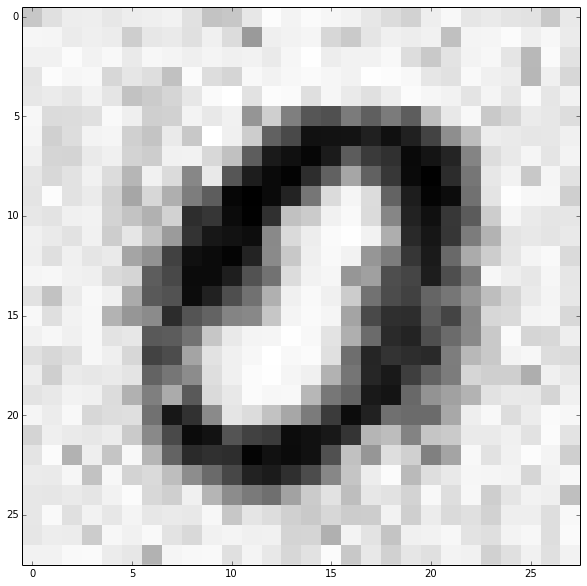

In [38]:
index = numpy.random.randint(5)
fig = plt.figure(figsize=(10,10))
plt.imshow(generate_images[index], cmap="Greys", interpolation="none")
plt.show()

Well ... It's OK.  It's very obviously not a digit, but it looks a bit like it *could* be a digit.  If you train this network on specific digits (1, 2,etc) I'm sure you will get much better performance.  Why not try it?